In [1]:
import numpy as np
import os

import pandas as pd
import torch
import pickle

from tqdm import tqdm
from itertools import repeat
from util import *
from visualization import *
from multiprocessing import Pool

In [2]:
from minio import Minio

client = Minio("minio.pish.pstu.ru:80", access_key="U28XMjtvu9y6IdsThVBK", secret_key="tK0xuwoYxFBRSOLHy7dMdhD7ec6JZH7lSUNd5PXR", secure=False)

bucket_name = "ai-data"
folder_name = "scitinder_data"
for item in client.list_objects(bucket_name, recursive=True):
    if folder_name in item.object_name:
        client.fget_object(bucket_name, item.object_name, item.object_name)

In [2]:
def get_required_idxs(author_df, organization_df, organization_name):
    """Позволяет получить индексы авторов, которые входят в указанную организацию

    :param author_df: сущность "author"
    :param organization_df: сущность "organization"
    :param organization_name: название организации для которой считается статистика
    :return: required_idxs: список требуемых индексов
    """

    required_idx = organization_df[organization_df["name"] == organization_name].index.values[0] + 1
    author_df = author_df[author_df["organization_id"] == float(required_idx)]
    required_idxs = author_df.index.values + 1
    return required_idxs


def entourage_coverage(adjacency_list, required_idxs=None, k=5, parallel=False):
    """
    :param adjacency_list: список смежности (словарь, где key - индекс автора, value - индексы соавторов)
    :param required_idxs: список требуемых индексов авторов для подсчета статистики
    :param k: порядок окружение, вплоть до которого производится расчет статистики
    :param parallel: выполнение функции в режиме multiprocessing
    :return:
    """

    if required_idxs is None:
        required_idxs = list(adjacency_list.keys())

    if parallel:
        with Pool() as pool:
            source_entourages = list(pool.starmap(
                    find_entourage_for_stats,
                    zip(repeat(adjacency_list), required_idxs, repeat(k))
                )
            )
    else:
        source_entourages = []
        for source_id in tqdm(required_idxs):
            tree = find_entourage_for_stats(adjacency_list, source_id, k)
            source_entourages.append(tree)
    return source_entourages


def handshake_distribution(adjacency_list, required_idxs=None, k=10, parallel=False):
    """

    :param adjacency_list: список смежности (словарь, где key - индекс автора, value - индексы соавторов)
    :param required_idxs: список требуемых индексов авторов для подсчета статистики
    :param k: порядок окружение, вплоть до которого производится расчет статистики (количество bins в распределении)
    :param parallel: выполнение функции в режиме multiprocessing
    :return:
    """
    if required_idxs is None:
        required_idxs = list(adjacency_list.keys())

    handshake_number = []
    if parallel:
        for source_id in tqdm(required_idxs):
            with Pool() as pool:
                distances = list(pool.starmap(
                    source_target_distance,
                    zip(repeat(adjacency_list), repeat(source_id), list(adjacency_list.keys()), repeat(k // 2))
                ))
            handshake_number.append(distances)
        handshake_number = flatten(handshake_number)
    else:
        for source_id in tqdm(required_idxs):
            for target_id in list(adjacency_list.keys()):
                source_tree, target_tree, inter = find_tree_from_list(adjacency_list, source_id, target_id, k // 2)
                if inter is not None:
                    handshake_number.append(len(source_tree.keys()) + len(target_tree.keys()))
    return handshake_number

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


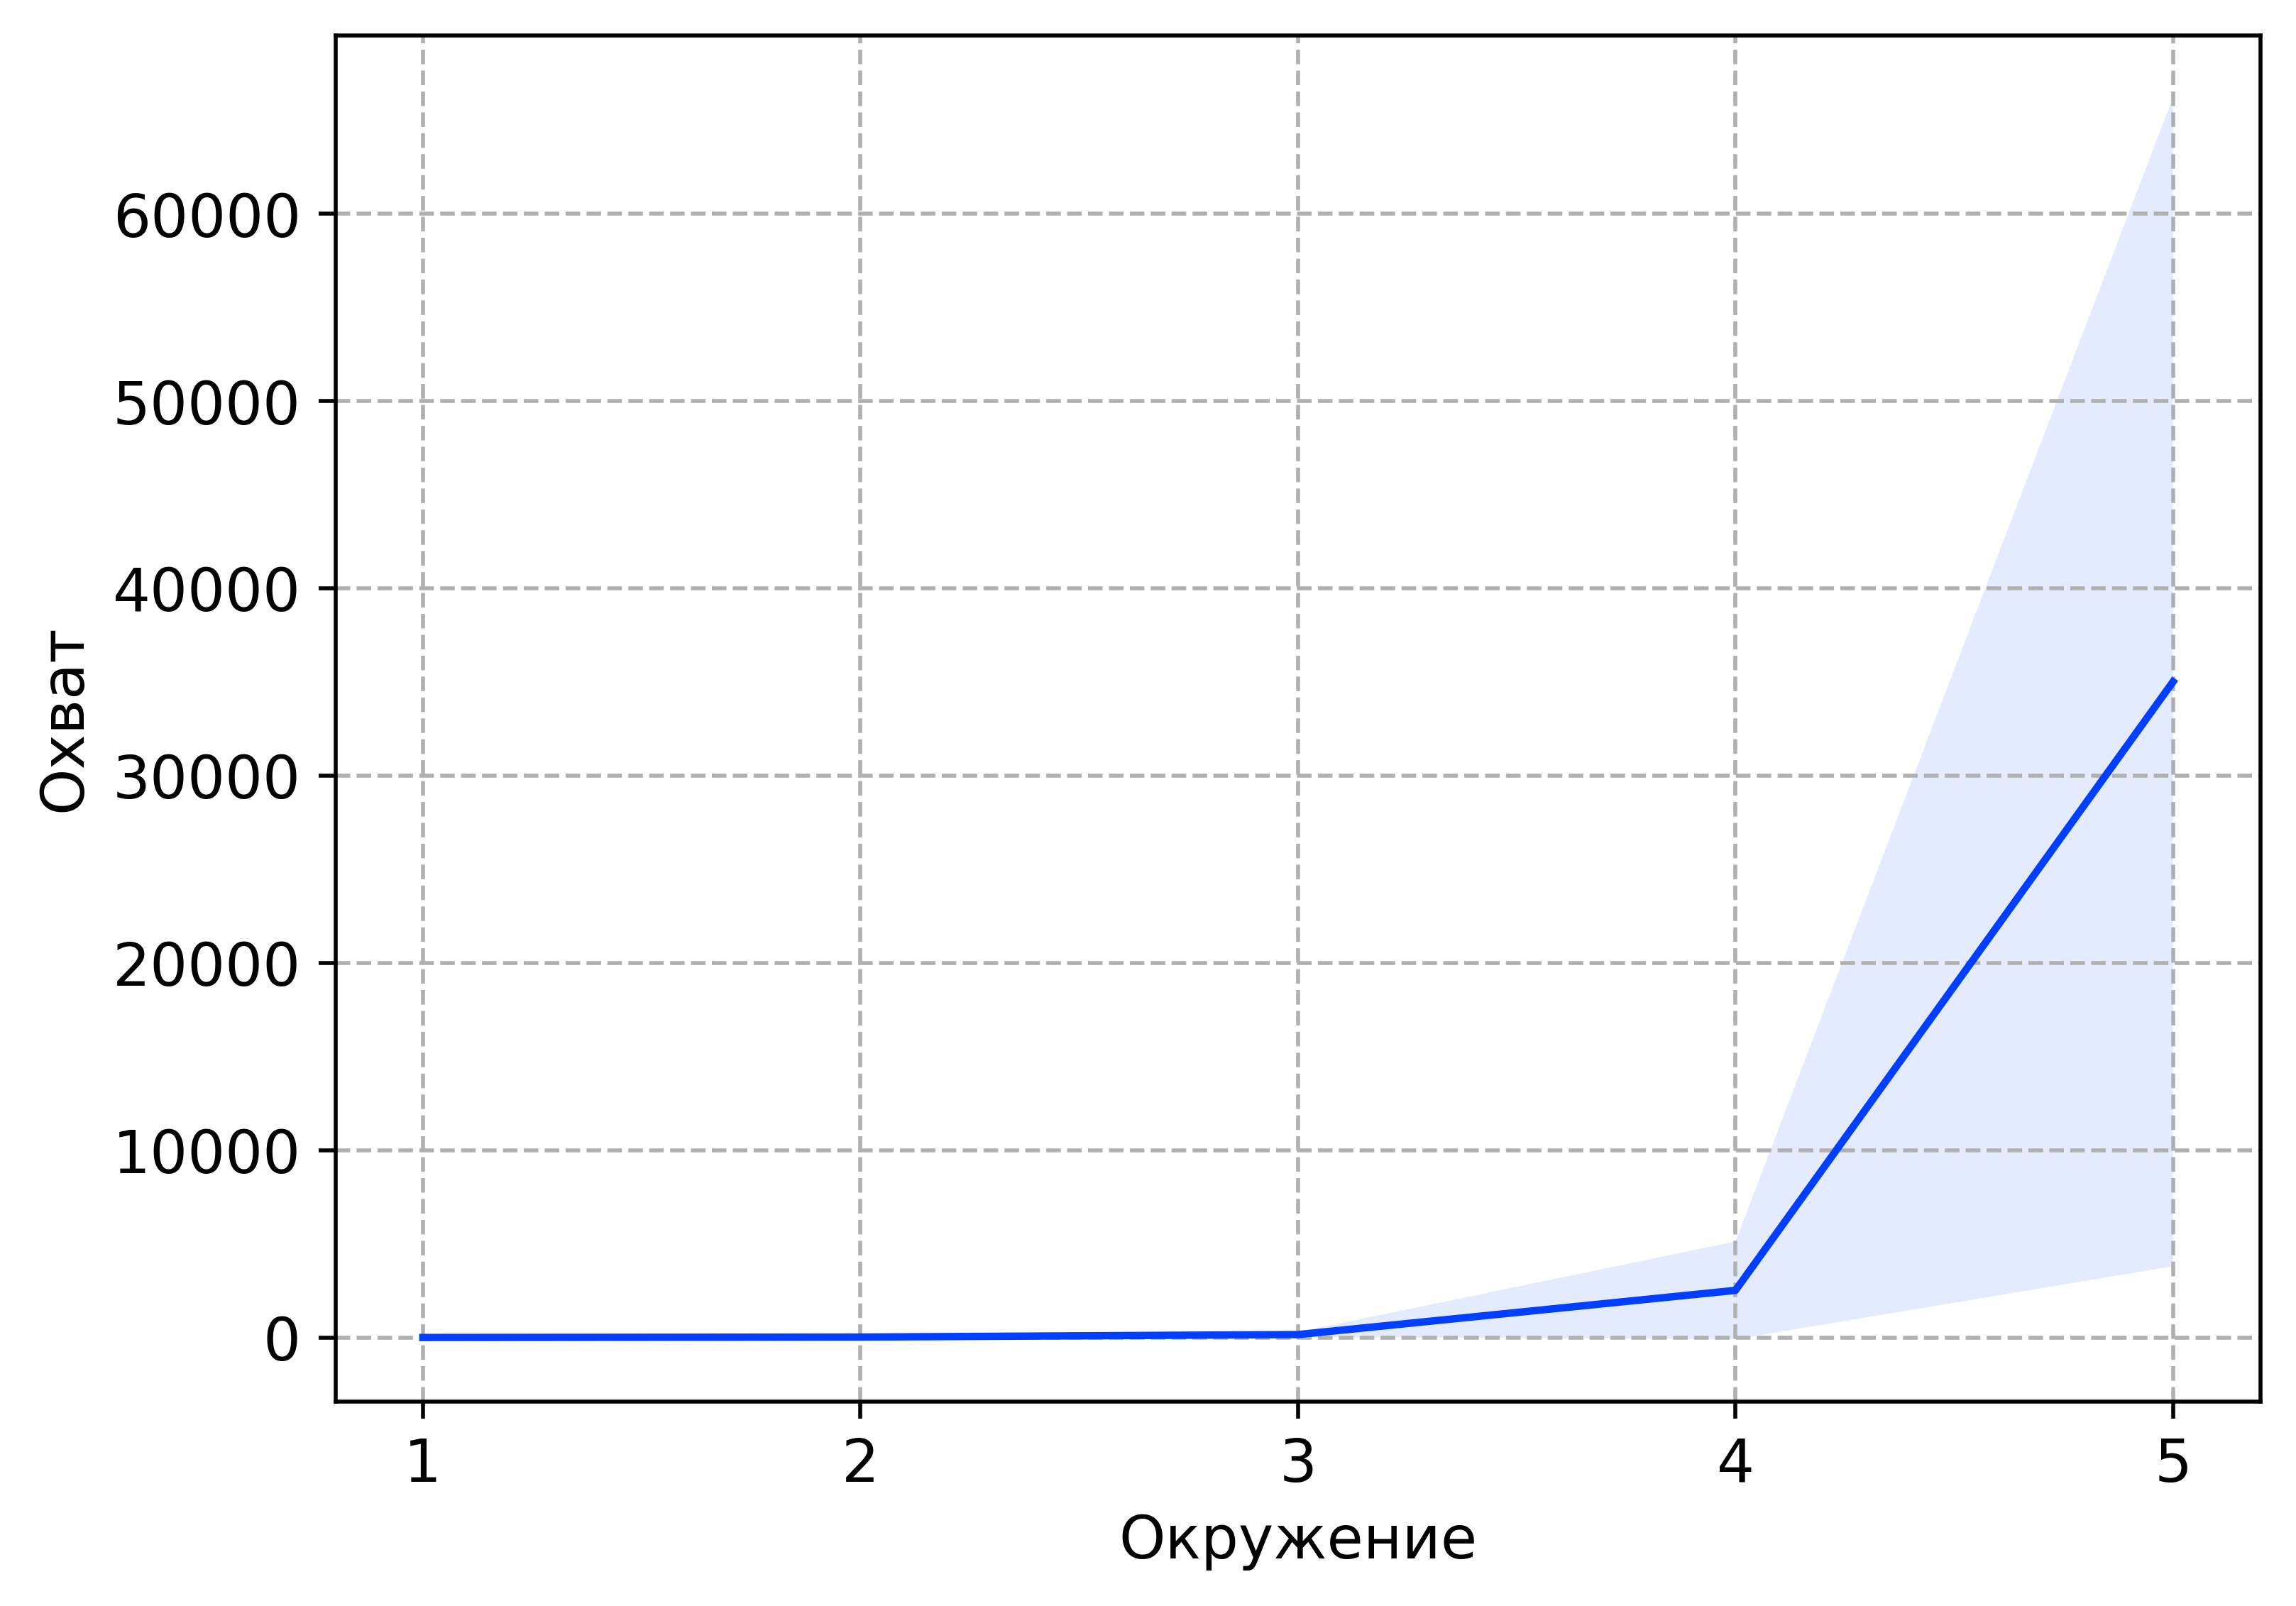

In [4]:
if __name__ == "__main__":
    root_path = r"scitinder_data"
    root_path_parquet = r"scitinder_data"
    adjacency_list_path = os.path.join(root_path, "adjacency_list.pkl")
    embedding_idxs_path = os.path.join(root_path, "idxs_all-mpnet-base-v2.pt")
    author_path = os.path.join(root_path_parquet, "author.parquet")
    organization_path = os.path.join(root_path_parquet, "organization.parquet")

    author_df = pd.read_parquet(author_path)
    organization_df = pd.read_parquet(organization_path)
    with open(adjacency_list_path, "rb") as f:
        adjacency_list = pickle.load(f)
    embedding_idxs = torch.load(embedding_idxs_path)

    author_df = author_df.iloc[embedding_idxs - 1]
    organization_name = "PAWLIN Technologies LLC"

    required_idxs = get_required_idxs(author_df, organization_df, organization_name)

    source_entourages = entourage_coverage(adjacency_list, required_idxs, 5)
    plot_entourage_coverage(source_entourages)

    #handshake_number = handshake_distribution(adjacency_list, required_idxs, k=5)